In [1]:
import tkinter as tk
from tkinter import messagebox
import random
import copy

In [2]:
course_entries = []  # List to store entry widgets for courses
lecturer_entries = []  # List to store entry widgets for lecturers
courses = []  # List to store course names
lecturers = []  # List to store lecturer names
weekdays = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday"]
time_slots = ["Slot1", "Slot2", "Slot3", "Slot4", "Slot5"]
assignment = []

In [3]:
def genAlgFun():
    # List of Time Slots
    time_slots = ["Slot1", "Slot2", "Slot3", "Slot4", "Slot5"]

    # List of Days
    days = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday"]

    # Course Requirements Matrix
    # The matrix is a dictionary where keys are tuples (lecturer, course) and values are integers representing hours per week.
    course_requirements = {}

    # Assign random values to the integers
    for lecturer in lecturers:
        for course in courses:
            key = (lecturer, course)
            course_requirements[key] = random.randint(0, 3)  # You can adjust the range of random values as needed

    # Print the updated course requirements
    for key, value in course_requirements.items():
        print(f"{key}: {value}")
    
    
    ########################################################################################################
    # Chromosome representation
    # Each gene in the chromosome represents an assignment of a course to a lecturer

    def generate_chromosome():
        chromosome = []

        for lecturer in lecturers:
            for course in courses:
                # Randomly assign a time slot and day for each course
                time_slot = random.choice(time_slots)
                day = random.choice(days)
                chromosome.append((lecturer, course, time_slot, day))

        return chromosome

    # Example usage
    chromosome = generate_chromosome()
    print("Chromosome:\n", chromosome)
    
    
    
    ########################################################################################################
    # Function to initialize a population
    def initialize_population( population_size):
        population = []

        for _ in range(population_size):
            chromosome = generate_chromosome()
            population.append(chromosome)

        return population

    # Example usage
    population_size = 5
    population = initialize_population(population_size)

    # Print the initialized population
    for i, chromosome in enumerate(population, start=1):
        print(f"Chromosome {i}: {chromosome}\n")
        
    
    ########################################################################################################
    # Fitness function
    def fitness(chromosome, course_requirements):
        total_penalty = 0

        # Dictionary to keep track of assigned hours for each lecturer and course
        assigned_hours = {(lecturer, course): 0 for lecturer in set(lecturer for lecturer, _, _, _ in chromosome) for course in set(course for _, course, _, _ in chromosome)}

        # Calculate penalties based on assigned hours and course requirements
        for assignment in chromosome:
            lecturer, course, time_slot, day = assignment
            assigned_hours[(lecturer, course)] += 1

            # Check if the assigned hours exceed the course requirements
            required_hours = course_requirements.get((lecturer, course), 0)
            penalty = max(0, assigned_hours[(lecturer, course)] - required_hours)
            total_penalty += penalty

            # Check for schedule conflicts (same time slot and day)
            conflicts = [other_assignment for other_assignment in chromosome if other_assignment != assignment and other_assignment[2:] == (time_slot, day)]
            total_penalty += len(conflicts)

        # Lower fitness value is better, so return the negative of the total penalty
        return -total_penalty

    # Example usage
    example_chromosome = generate_chromosome()
    example_fitness = fitness(example_chromosome, course_requirements)

    print("Example Chromosome:", example_chromosome)
    print("Fitness:", example_fitness)
    
    
    ########################################################################################################
    # Roulette wheel selection based on fitness
    def roulette_wheel_selection(population, fitness_values):
        selected_population = []
        total_fitness = sum(fitness_values)

        for _ in range(len(population)):
            pick = random.uniform(0, total_fitness)
            current_sum = 0
            for i, fitness_value in enumerate(fitness_values):
                current_sum += fitness_value
                if current_sum >= pick:
                    selected_population.append(population[i])
                    break

        return selected_population

    # Example usage
    population_size = 10
    population = initialize_population(population_size)

    # Evaluate fitness for each chromosome in the population
    fitness_values = [fitness(chromosome, course_requirements) for chromosome in population]

    # Perform fitness-based selection
    selected_population = roulette_wheel_selection(population, fitness_values)

    # Print the results
    print("Original Population:")
    for i, chromosome in enumerate(population, start=1):
        print(f"Chromosome {i}: {chromosome}, Fitness: {fitness_values[i-1]}\n")

    print("\nSelected Population:")
    for i, chromosome in enumerate(selected_population, start=1):
        print(f"Chromosome {i}: {chromosome}, Fitness: {fitness_values[i-1]}\n")
        
        
    ########################################################################################################
    # Crossover: One-Point Crossover
    def one_point_crossover(parent1, parent2):
        crossover_point = random.randint(0, len(parent1) - 1)
        child1 = parent1[:crossover_point] + parent2[crossover_point:]
        child2 = parent2[:crossover_point] + parent1[crossover_point:]
        return child1, child2

    # Mutation: Swap Mutation
    def swap_mutation(individual):
        mutated_individual = copy.deepcopy(individual)
        mutation_point1, mutation_point2 = random.sample(range(len(mutated_individual)), 2)
        mutated_individual[mutation_point1], mutated_individual[mutation_point2] = mutated_individual[mutation_point2], mutated_individual[mutation_point1]
        return mutated_individual

    # Replacement: Generational Replacement
    def generational_replacement(current_population, offspring_population, course_requirements):
        combined_population = current_population + offspring_population
        combined_fitness = [fitness(individual, course_requirements) for individual in combined_population]
        combined_population, combined_fitness = zip(*sorted(zip(combined_population, combined_fitness), key=lambda x: x[1], reverse=True))
        return combined_population[:len(current_population)]

    # Example usage
    population_size = 5
    population = initialize_population(population_size)

    # Evaluate fitness for each chromosome in the population
    fitness_values = [fitness(chromosome, course_requirements) for chromosome in population]

    # Perform genetic operations (crossover and mutation)
    selected_parents = roulette_wheel_selection(population, fitness_values)
    offspring_population = []

    for i in range(0, len(selected_parents), 2):
        parent1 = selected_parents[i]
        parent2 = selected_parents[i + 1] if i + 1 < len(selected_parents) else None

        # Apply crossover
        if parent2:
            child1, child2 = one_point_crossover(parent1, parent2)
        else:
            child1 = copy.deepcopy(parent1)
            child2 = None

        # Apply mutation
        child1 = swap_mutation(child1)

        # Add offspring to the population
        offspring_population.extend([child1, child2] if child2 else [child1])

    # Perform generational replacement
    population = generational_replacement(population, offspring_population, course_requirements)

    # Print the results
    print("Original Population:")
    for i, chromosome in enumerate(population, start=1):
        print(f"Chromosome {i}: {chromosome}, Fitness: {fitness_values[i-1]}")

    print("\nOffspring Population:")
    for i, chromosome in enumerate(offspring_population, start=1):
        print(f"Chromosome {i}: {chromosome}, Fitness: {fitness(chromosome, course_requirements)}")
        
    
    ########################################################################################################
    # Replacement: Generational Replacement
    def generational_replacement(current_population, offspring_population, course_requirements):
        combined_population = current_population + offspring_population
        combined_fitness = [fitness(individual, course_requirements) for individual in combined_population]
        combined_population, combined_fitness = zip(*sorted(zip(combined_population, combined_fitness), key=lambda x: x[1], reverse=True))
        return list(combined_population)[:len(current_population)]

    # Function to perform genetic algorithm for a given number of generations
    def genetic_algorithm(population_size, num_generations):
        population = initialize_population(population_size)

        for generation in range(num_generations):
            # Evaluate fitness for each chromosome in the population
            fitness_values = [fitness(chromosome, course_requirements) for chromosome in population]

            # Perform fitness-based selection
            selected_parents = roulette_wheel_selection(population, fitness_values)
            offspring_population = []

            # Apply crossover and mutation
            for i in range(0, len(selected_parents), 2):
                parent1 = selected_parents[i]
                parent2 = selected_parents[i + 1] if i + 1 < len(selected_parents) else None

                # Apply crossover
                if parent2:
                    child1, child2 = one_point_crossover(parent1, parent2)
                else:
                    child1 = copy.deepcopy(parent1)
                    child2 = None

                # Apply mutation
                child1 = swap_mutation(child1)

                # Add offspring to the population
                offspring_population.extend([child1, child2] if child2 else [child1])

            # Perform generational replacement
            population = generational_replacement(population, offspring_population, course_requirements)

            # Print the results for each generation
            print(f"Generation {generation + 1}: Best Fitness - {fitness_values[0]}")

        # Return the final population
        return population

    # Example usage
    population_size = 5
    num_generations = 10
    final_population = genetic_algorithm(population_size, num_generations)

    # Print the final population
    print("\nFinal Population:")
    for i, chromosome in enumerate(final_population, start=1):
        print(f"Chromosome {i}: {chromosome}, Fitness: {fitness(chromosome, course_requirements)}\n")
        
        
    ########################################################################################################
    # Function to find the best chromosome in the final population
    def find_best_chromosome(final_population, course_requirements):
        fitness_values = [fitness(chromosome, course_requirements) for chromosome in final_population]
        best_index = fitness_values.index(max(fitness_values))
        return final_population[best_index]

    # Example usage
    population_size = 5
    num_generations = 10
    final_population = genetic_algorithm(population_size, num_generations)

    # Find the best chromosome in the final population
    best_chromosome = find_best_chromosome(final_population, course_requirements)

    # Output the best timetable schedule
    print("\nBest Timetable Schedule:")
    print("\n best_chromosome first", best_chromosome[0])
    for assignment in best_chromosome:
        lecturer, course, time_slot, day = assignment
        print(f"Lecturer: {lecturer}, Course: {course}, Time Slot: {time_slot}, Day: {day}")
    assignment = best_chromosome
    return assignment
    
    



    

In [4]:
def create_table(root, assignment):
    # Create a table with rows for weekdays, a header row for time, and a header column for weekdays

    # Create header row for time
    for j, time_slot in enumerate(time_slots):
        label = tk.Label(root, text=time_slot, borderwidth=1, relief="solid", width=20, height=3)
        label.grid(row=0, column=j + 1)  # Shift by 1 to leave space for the weekday column

    # Create header column for weekdays
    for i, weekday in enumerate(weekdays):
        label = tk.Label(root, text=weekday, borderwidth=1, relief="solid", width=20, height=3)
        label.grid(row=i + 1, column=0)  # Shift by 1 to leave space for the time header

    # Create empty cells for the body of the table
    for i, weekday in enumerate(weekdays):
        for j, time_slot in enumerate(time_slots):
            label_text = ""
            for assignment_item in assignment:
                if assignment_item[2:] == (time_slot, weekday):
                    label_text = f"{assignment_item[0]} - {assignment_item[1]}"
            label = tk.Label(root, text=label_text, borderwidth=1, relief="solid", width=20, height=3)
            label.grid(row=i + 1, column=j + 1)

    print("end assignment", assignment)

def create_dynamic_inputs(parent, num1, num2):
    dynamic_inputs_window = tk.Toplevel(parent)
    dynamic_inputs_window.title("Dynamic Inputs")

    def add_values_to_lists_and_call_genAlgFun():
        for i in range(min(num1, len(course_entries))):
            course_value = course_entries[i].get()
            courses.append(course_value)

        for i in range(min(num2, len(lecturer_entries))):
            lecturer_value = lecturer_entries[i].get()
            lecturers.append(lecturer_value)

        print("Courses:", courses)
        print("Lecturers:", lecturers)

        # Call the genAlgFun function
        # ...

        # After dynamic inputs, create the timetable panel
        create_table(root, genAlgFun())


    for i in range(num1):
        tk.Label(dynamic_inputs_window, text=f"Enter Value {i+1} for Lecturer:").grid(row=i, column=0)
        entry = tk.Entry(dynamic_inputs_window)
        entry.grid(row=i, column=1)
        lecturer_entries.append(entry)

    for i in range(num2):
        tk.Label(dynamic_inputs_window, text=f"Enter Value {i+1} for Course:").grid(row=i, column=2)
        entry = tk.Entry(dynamic_inputs_window)
        entry.grid(row=i, column=3)
        course_entries.append(entry)

    tk.Button(dynamic_inputs_window, text="Add to Lists and Call genAlgFun",
              command=add_values_to_lists_and_call_genAlgFun).grid(row=num1, columnspan=4, pady=5)

def show_inputs():
    input_window = tk.Toplevel(root)
    input_window.title("Enter Numbers")

    tk.Label(input_window, text="Enter First Number:").grid(row=0, column=0)
    first_number_entry = tk.Entry(input_window)
    first_number_entry.grid(row=0, column=1)

    tk.Label(input_window, text="Enter Second Number:").grid(row=1, column=0)
    second_number_entry = tk.Entry(input_window)
    second_number_entry.grid(row=1, column=1)

    def show_next_inputs():
        try:
            num1 = int(first_number_entry.get())
            num2 = int(second_number_entry.get())

            create_dynamic_inputs(input_window, num1, num2)

        except ValueError:
            messagebox.showerror("Error", "Please enter valid numbers.")

    tk.Button(input_window, text="Show Next Inputs", command=show_next_inputs).grid(row=2, columnspan=2, pady=5)

if __name__ == "__main__":
    course_entries = []
    lecturer_entries = []
    courses = []
    lecturers = []
    root = tk.Tk()
    root.title("School Timetable")

    # Show the "Show Inputs" window first
    show_inputs()

    root.mainloop()

Courses: ['sadqfv', 'dfasca']
Lecturers: ['adasd', 'asdasd']
('adasd', 'sadqfv'): 2
('adasd', 'dfasca'): 2
('asdasd', 'sadqfv'): 3
('asdasd', 'dfasca'): 0
Chromosome:
 [('adasd', 'sadqfv', 'Slot2', 'Wednesday'), ('adasd', 'dfasca', 'Slot1', 'Thursday'), ('asdasd', 'sadqfv', 'Slot2', 'Wednesday'), ('asdasd', 'dfasca', 'Slot2', 'Sunday')]
Chromosome 1: [('adasd', 'sadqfv', 'Slot3', 'Sunday'), ('adasd', 'dfasca', 'Slot3', 'Tuesday'), ('asdasd', 'sadqfv', 'Slot4', 'Tuesday'), ('asdasd', 'dfasca', 'Slot1', 'Sunday')]

Chromosome 2: [('adasd', 'sadqfv', 'Slot3', 'Wednesday'), ('adasd', 'dfasca', 'Slot5', 'Tuesday'), ('asdasd', 'sadqfv', 'Slot5', 'Wednesday'), ('asdasd', 'dfasca', 'Slot3', 'Sunday')]

Chromosome 3: [('adasd', 'sadqfv', 'Slot2', 'Tuesday'), ('adasd', 'dfasca', 'Slot3', 'Thursday'), ('asdasd', 'sadqfv', 'Slot4', 'Wednesday'), ('asdasd', 'dfasca', 'Slot1', 'Thursday')]

Chromosome 4: [('adasd', 'sadqfv', 'Slot3', 'Tuesday'), ('adasd', 'dfasca', 'Slot1', 'Thursday'), ('asdasd', '

### 

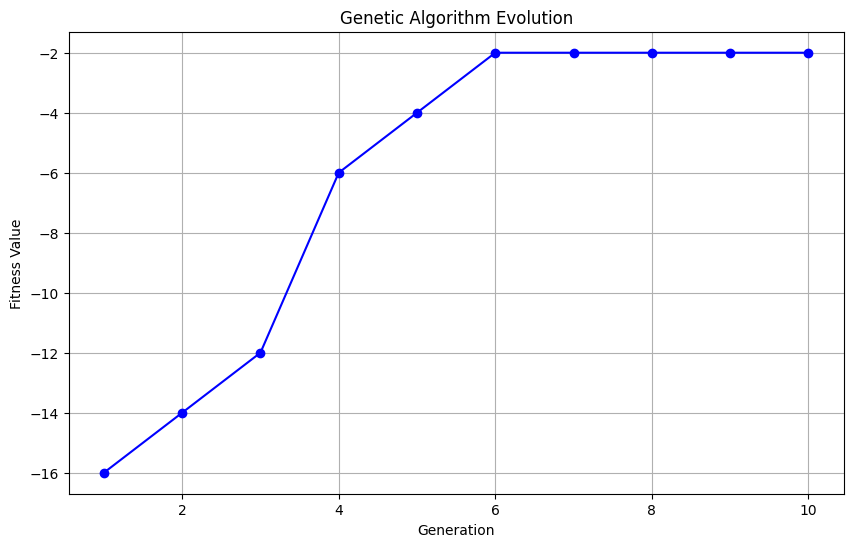

In [1]:
# plotting for the fitness values along 10 Generations 
import matplotlib.pyplot as plt
import numpy as np

# Hypothetical data (replace this with your actual algorithm's output)
generations = np.arange(1, 11)  # Number of generations
fitness_values = np.array([-16, -14, -12, -6, -4, -2, -2, -2, -2, -2])  # Fitness values for each generation

# Plotting the evolution of fitness values
plt.figure(figsize=(10, 6))
plt.plot(generations, fitness_values, marker='o', linestyle='-', color='b')
plt.title("Genetic Algorithm Evolution")
plt.xlabel("Generation")
plt.ylabel("Fitness Value")
plt.grid(True)
plt.show()